# Goal of this notebook

In this notebook, we model the delays of edges (trajectory going from a stop to another.) using the given ist_daten dataset. First of all, we noticed that lot of the stop ids present in the timetable dataset are not in istdaten. This is the reason why we decided to operate using two levels of granularity :
1) For edges that are not in ist_daten we consider that their delays can be modeled using statistics computed on edges having similar transport type and operating in the same time category.


2) For edges that are present in the istdaten dataset their exact delays. Thus, we compute a finer-grained estimation of these delays. 

Topology: an edge denotes a trajectory going from a stop to another. We identify such an edge using a starting stop id, an ending stop id, and a transport group.

# Init spark

In [60]:
%%local
import os
username = os.environ['JUPYTERHUB_USER']

# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic('configure', line="-f", cell='{ "name":"%s-finalproject3", "executorMemory":"6G", "executorCores":4, "numExecutors":10, "driverMemory": "4G" }' % username)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7191,application_1618324153128_6906,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7161,application_1618324153128_6866,pyspark,idle,Link,Link,None,
7165,application_1618324153128_6871,pyspark,idle,Link,Link,None,
7171,application_1618324153128_6877,pyspark,idle,Link,Link,None,
7176,application_1618324153128_6883,pyspark,idle,Link,Link,None,
7178,application_1618324153128_6885,pyspark,idle,Link,Link,None,
7179,application_1618324153128_6886,pyspark,idle,Link,Link,None,
7183,application_1618324153128_6897,pyspark,idle,Link,Link,None,
7184,application_1618324153128_6899,pyspark,idle,Link,Link,None,
7188,application_1618324153128_6903,pyspark,idle,Link,Link,None,
7191,application_1618324153128_6906,pyspark,idle,Link,Link,None,✔


In [61]:
%%send_to_spark -i username -t str -n username

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'username' as 'username' to Spark kernel

In [62]:
print('We are using Spark %s' % spark.version)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We are using Spark 2.3.2.3.1.4.0-315

In [63]:
spark.sparkContext.addPyFile('hdfs:///user/boesinge/finalproject/data_utils.py')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Imports

In [64]:
import data_utils
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark
import datetime

from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from scipy.stats import gamma, zscore

from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.window import Window

from functools import reduce
from pyspark.sql import DataFrame

import matplotlib
matplotlib.use('agg')
import matplotlib.pylab as plt

from pandas.compat import StringIO
pd.set_option('display.max_columns', 500)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# PART I : Fitting Gammas

## Load Sampled Istdaten Data and Fit gamma
For the first level of granularity we use a sample version of the istdaten dataset containing (approximately) an equal number of edges from each transport type. 

In [65]:
istdaten_sampled = sqlContext.read.load('/user/boesinge/finalproject/istdaten_sampled.parquet')
istdaten_sampled.groupby('fullgroup', 'transport_group', 'time_category').count().orderBy('fullgroup').show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------+-------------+-----+
|fullgroup|transport_group|time_category|count|
+---------+---------------+-------------+-----+
|      B,0|              B|            0| 1026|
|      B,1|              B|            1| 1021|
|      B,2|              B|            2|  992|
|      B,3|              B|            3| 1013|
|      B,4|              B|            4| 1003|
+---------+---------------+-------------+-----+
only showing top 5 rows

## Fitting Gammas Distributions
Now we group by the time and transport categories identified in the "time_tranposrt_cat.ipynb" notebook. Then we fit gammas distribution to each group of delays. We chose to use gammas to represent de delays because of the papers we read about stochastic routing. Moreover, we can come to this conclusion also by looking at the histograms of the delays. 

In [66]:
delays_grouped = istdaten_sampled.groupby(['transport_group', 'time_category']).agg(F.collect_list('arrival_delay').alias('delays')).cache()

delays_gammas = data_utils.distribution_fitting(delays_grouped).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Visualizing Fitted Gammas

In [67]:
gammas_df = data_utils.sample_delays(delays_gammas, ['transport_group','time_category'])

ncols,nrows= 5,8
fig, axs = plt.subplots(ncols=ncols,nrows=nrows, figsize=(20,10))

for i,ax in zip(range(ncols*nrows),axs.flatten()):
    curr_data = gammas_df.iloc[i]
    data_utils.plot_distri(curr_data,ax)
    ax.set_title("transport :" + str(curr_data.transport_group) + " time_cat : " + str(curr_data.time_category)  )

plt.show()
plt.tight_layout()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

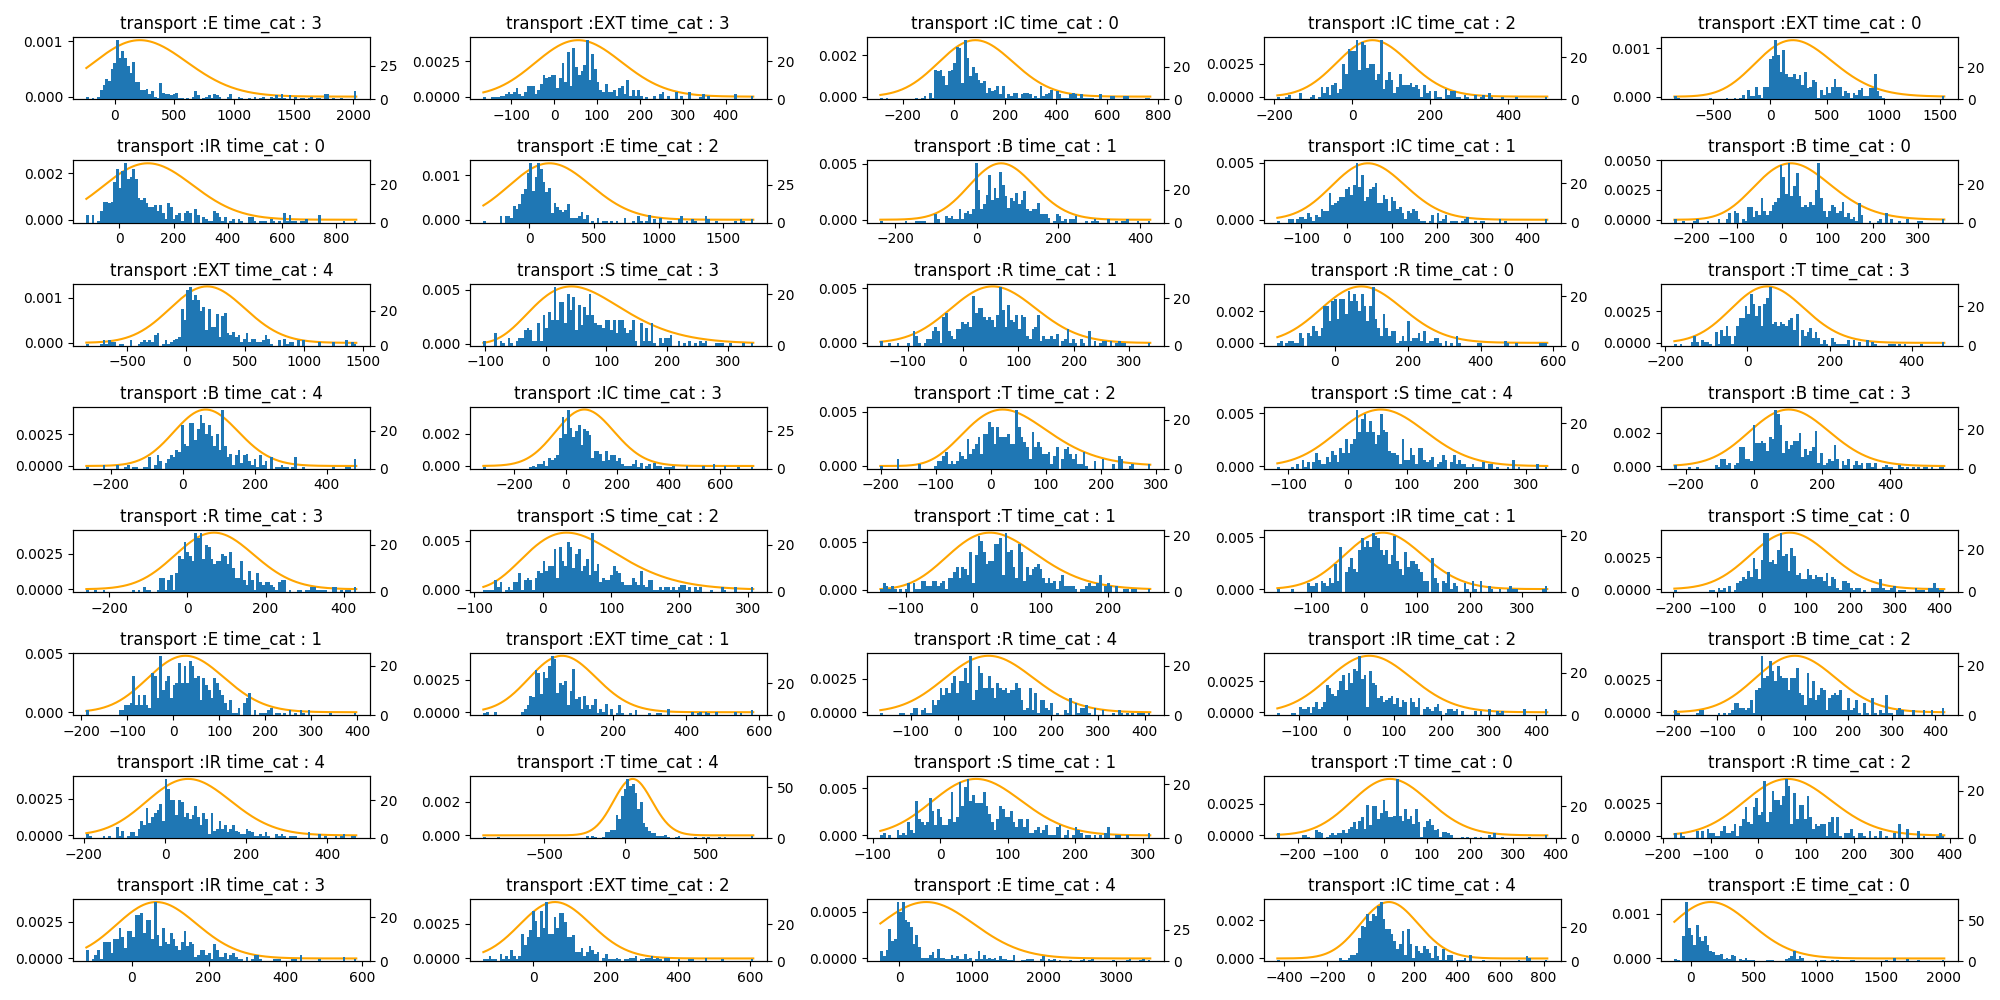

In [68]:
%matplot plt

# Merging with Timetable
Now, using the timetable dataset we create a new data frame containing all the edges located in Zurich. Then we add the information about the fitted gammas in this new dataset

## Loading the csv dataframes

In [69]:
trips_df = sqlContext.read.format("csv").options(header='true').load('/data/sbb/csv/timetable/trips/2019/05/07/trips.csv')
routes_df = sqlContext.read.format("csv").options(header='true').load('/data/sbb/csv/timetable/routes/2019/05/07/routes.csv')
stops_fulldf = sqlContext.read.format("csv").options(header='true').option("delimiter", ";").load('/data/sbb/csv/geostops/geostops.csv')
calendar_df = sqlContext.read.format("csv").options(header='true').load('/data/sbb/csv/timetable/calendar/2019/05/07/calendar.csv')
stops_df = sqlContext.read.load('/user/boesinge/finalproject/stops_20km.parquet')

timetable_df = (sqlContext.read.format("csv").options(header='true')
                .load('/data/sbb/csv/timetable/stop_times/2019/05/07/stop_times.csv')
                .withColumn('stop_id', data_utils.split_tops_df('stop_id'))
               )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filter calendar (select right weekdays)

In [70]:
start_date = datetime.date(2019,5,13)
end_date   = datetime.date(2019,5,17)

calendar_df = (calendar_df
 .withColumn('start_date', F.to_date(calendar_df.start_date, 'yyyyMMdd'))
 .withColumn('end_date', F.to_date(calendar_df.end_date, 'yyyyMMdd'))
 .filter(F.col('start_date') < start_date)
 .filter(F.col('end_date') > end_date)
 .filter((F.col('monday') == 1) | (F.col('tuesday') == 1) | (F.col('wednesday') == 1) | (F.col('thursday') == 1) | (F.col('friday') == 1))
).select('service_id')


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filter timetables with calendar, stops information

In [71]:
selection_df = trips_df.join(calendar_df, 'service_id').select('trip_id').drop_duplicates()

timetable_filtered = (timetable_df
                .join(selection_df, 'trip_id')
                .join(trips_df,     'trip_id')
                .join(routes_df,    'route_id')
                .join(stops_df,     'stop_id')
                .filter(F.col('route_desc').isin(data_utils.routes_to_groups.keys()))
                .withColumn('transport_group', data_utils.routes_group('route_desc'))
               )

timetable_filtered.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1390479

## Collecting Timetable Data to (Departure, Arrival) format

In [72]:
timetable_with_timecat = (timetable_filtered
                            .withColumn('time_category', data_utils.time_cat(F.hour(F.from_unixtime(F.unix_timestamp('arrival_time', 'HH:mm:ss')))))
                            .withColumn("id", monotonically_increasing_id())
                         )

w = Window().partitionBy('trip_id').orderBy(F.col("id"))
# form the edge dataset
edges = (timetable_with_timecat
     .withColumn("dep_stop_id" , F.lag("stop_id").over(w))
     .withColumn("dep_time", F.lag("departure_time").over(w))
     .withColumn("dep_stop_name", F.lag("stop_name").over(w))
     .withColumn("dep_stop_sequence", F.lag('stop_sequence').over(w))
     .filter(~F.col('stop_sequence').isNull())
     .filter(F.col('stop_sequence') == (F.col('dep_stop_sequence')+1))
     .filter(F.col('dep_stop_sequence').cast('int') < F.col('stop_sequence').cast('int'))
     .withColumnRenamed('stop_id'      , 'arr_stop_id')
     .withColumnRenamed('arrival_time' , 'arr_time')
     .withColumnRenamed('stop_name'    , 'arr_stop_name')
     .filter(F.col('dep_stop_id') != F.col('arr_stop_id'))
     .select(["trip_id", 'dep_stop_id', 'arr_stop_id', 'dep_time', 'arr_time', 'dep_stop_name', 'arr_stop_name','route_desc', 'stop_sequence', 'transport_group', 'time_category'])
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Joining Gammas with Timetable Data
Here we add the gammas parameters in the edges dataset.

In [73]:
edges_with_gammas = edges.join(delays_gammas.select('time_category','transport_group', 'gammas'), ['time_category','transport_group'])

geo_data = stops_df.select('stop_id','stop_lat','stop_lon')

edges_with_gammas = edges_with_gammas.join(geo_data,geo_data.stop_id==edges_with_gammas.dep_stop_id)\
                .withColumnRenamed('stop_lat','start_lat')\
                .withColumnRenamed('stop_lon','start_lon')\
                .drop('stop_id')
edges_with_gammas = edges_with_gammas.join(geo_data,geo_data.stop_id==edges_with_gammas.arr_stop_id)\
                .withColumnRenamed('stop_lat','end_lat')\
                .withColumnRenamed('stop_lon','end_lon')\
                .drop('stop_id')\
                .cache() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Small Verifications

In [74]:
assert edges_with_gammas.filter(F.col('dep_time') > F.col('arr_time')).count() == 0

assert edges_with_gammas.filter(F.col('dep_stop_id') == F.col('arr_stop_id')).count() == 0

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Part II : Fine-grained fitting
In the second part of the notebook, we proceed to the finer-grained estimation (described in the introduction)


First we load the full ist_daten dataset :

In [75]:
istdaten_df = sqlContext.read.format("orc").load('/data/sbb/orc/istdaten')

# by looking at the arrival and departure values we deduce the following formats
scheduled_format = "dd.MM.yyyy HH:mm"
actual_format   = "dd.MM.yyyy HH:mm:ss"

istdaten_df = (istdaten_df
    .withColumnRenamed('BETRIEBSTAG'        , 'trip_date')
    .withColumnRenamed('FAHRT_BEZEICHNER'   , 'trip_id')
    .withColumnRenamed('BETREIBER_ABK'      , 'operator_smallname')
    .withColumnRenamed('BETREIBER_NAME'     , 'operator_name')
    .withColumnRenamed('PRODUKT_ID'         , 'transport_type')
    .withColumnRenamed('LINIEN_ID'          , 'line_id')
    .withColumnRenamed('LINIEN_TEXT'        , 'line_text')
    .withColumnRenamed('VERKEHRSMITTEL_TEXT', 'service_type')
    .withColumnRenamed('ZUSATZFAHRT_TF'     , 'additional_trip')
    .withColumnRenamed('FAELLT_AUS_TF'      , 'trip_failed')
    .withColumnRenamed('HALTESTELLEN_NAME'  , 'stop_name')
    .withColumnRenamed('ANKUNFTSZEIT'       , 'scheduled_arrival_time')
    .withColumnRenamed('AN_PROGNOSE'        , 'actual_arrival_time')
    .withColumnRenamed('AN_PROGNOSE_STATUS' , 'actual_arrtime_measured')
    .withColumnRenamed('ABFAHRTSZEIT'       , 'scheduled_departure_time')
    .withColumnRenamed('AB_PROGNOSE'        , 'actual_departure_time')
    .withColumnRenamed('AB_PROGNOSE_STATUS' , 'actual_deptime_measured')
    .withColumnRenamed('DURCHFAHRT_TF'      , 'not_stopping_here')
    .withColumnRenamed('BPUIC'              , 'stop_id')
    .withColumnRenamed('BETREIBER_ID'       , 'operator_id')
    .withColumnRenamed('UMLAUF_ID'          , 'circuit_id')
    .withColumn("actual_arrival_time",F.unix_timestamp('actual_arrival_time', actual_format))\
    .withColumn("scheduled_arrival_time",F.unix_timestamp('scheduled_arrival_time', scheduled_format))\
    .withColumn("actual_departure_time",F.unix_timestamp('actual_departure_time', actual_format))\
    .withColumn("scheduled_departure_time",F.unix_timestamp('scheduled_departure_time', scheduled_format))
    .filter(F.col('additional_trip') == False)
    .filter(F.col('trip_failed') == False)
    .filter(F.col('actual_deptime_measured').isin(['REAL', 'GESCHAETZT']))
    .filter(F.col('actual_arrtime_measured').isin(['REAL', 'GESCHAETZT']))
    .filter(F.col('service_type').isin(data_utils.istdaten_to_groups.keys()))                              # Keep only transport types which are useful to us
    .filter(F.dayofweek(F.from_unixtime("scheduled_departure_time")).isin(['2','3','4','5','6'])) # Filter only weekdays
    .filter(F.hour(F.from_unixtime("scheduled_arrival_time"))<=24)                                # Keep only schedules in a single day
    .filter(~(F.col('transport_type').isNull()))                                                  # Keep only nonnull service and transport types
    .filter(~(F.col('service_type').isNull()))
    .withColumn('transport_group', data_utils.istdaten_group('service_type'))
    .withColumn('stop_id', data_utils.normalize_id('stop_id'))
)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We filter out the edges that are not in a 15km radius from the Zurich train station

In [76]:
# list of unique valid stops (we checked that the same stops are present in arr_stop_id )
stop_ids  = [x.dep_stop_id for x in edges_with_gammas.select('dep_stop_id').distinct().collect()]
# proceed to filtering
istdaten_15km_df = istdaten_df.filter(istdaten_df.stop_id.isin(stop_ids))
istdaten_15km_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

18795834

We construct edges from ist_daten and corresponding delays

In [77]:
istdaten_15km_df = data_utils.compute_arrival_departure(istdaten_15km_df)
delays = data_utils.compute_delays(istdaten_15km_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# add time category
delays = delays.withColumn("time_category" , data_utils.time_cat(F.hour(F.from_unixtime('scheduled_arrival_time'))))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Kmeans
Individual edges might not have enough delay data to properly fit a distribution. Thus, we group the edges together using a Kmean algorithm before fitting the gammas. In fact, we construct multiple clusterings: one per identified time categories.

First, we extract some useful features giving information about the distributions. As features, we use different (0.25,0.5,0.75,0.80) empirical quantiles of the delays. 

In [79]:
delays.createOrReplaceTempView("delays")

request = ("SELECT start,end,transport_group,time_category, percentile_approx(arrival_delay, 0.5) as med_val\n"
           ",percentile_approx(arrival_delay, 0.25) as 25_quantile \n"
           ",percentile_approx(arrival_delay, 0.75) as 75_quantile \n"
           ",percentile_approx(arrival_delay, 0.80) as 80_quantile \n"
           ",collect_list(arrival_delay) as delays"
           ",first(line_id) as line_id"
           ",mean(arrival_delay) as mean \n"
           ",std(arrival_delay) as std   \n"
           "FROM delays GROUP BY start,end,transport_group,time_category")

kmeans_df = sqlContext.sql(request).fillna(0).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
features = ['med_val', '25_quantile', '75_quantile', '80_quantile', 'mean', 'std']
# we vectorize the computed features
vecAssembler = VectorAssembler(outputCol="vectorized_features")
vecAssembler.setInputCols(features)

kmeans_df = vecAssembler.transform(kmeans_df).drop(*features)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
# initializing the scaler transform
scaler = StandardScaler(inputCol="vectorized_features", outputCol="kmeans_features", withStd=True, withMean=True)

# We standardize the features
kmeans_df = scaler.fit(kmeans_df).transform(kmeans_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
time_categories = [0,1,2,3,4]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
# Here we split the kmeans_df dataframe according the the time category of the edges
kmeans_dfs = [kmeans_df.filter(kmeans_df.time_category == cat).cache() for cat in time_categories]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
MAX_K = 10
k_range = [10, 25,30,35,40,60,100]

def get_kmeans_scores(df):
    '''Given a dataset df : compute the sum of squared errors and the silhouette scores of clusterings using different values of k'''
    silhouette_scores = []
    sum_squares = []
    # iterate over all k values
    for k in k_range:
        # create kmeans model
        kmeans = KMeans(k=k, seed=1, featuresCol='kmeans_features')

        # fit model to our df
        model = kmeans.fit(df)

        # get centers from fitted model
        centers = model.clusterCenters()
        # transform df to get the prediction
        transformed = model.transform(df)

        # create a silhouette score evaluator
        evaluator = ClusteringEvaluator(featuresCol="kmeans_features")
        # evaluate
        silhouette = evaluator.evaluate(transformed)
        # compute the sum of squared distance and save it
        wssse = model.computeCost(df)
        sum_squares.append(wssse)
        # save silhouette
        silhouette_scores.append(silhouette)
    return (silhouette_scores,sum_squares)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
# plot the scores

fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(30,30))
for i,ax in zip(range(len(time_categories)),axs.flatten()):
    silhouette,sse = get_kmeans_scores(kmeans_dfs[i])
    
    ax.plot(k_range, sse, label='sumsquares', color='orange')

    ax2 = ax.twinx()
    ax2.plot(k_range, silhouette, label='silhouette')

    ax.legend()
    ax2.set_title("scores for time category : " + str(time_categories[i]))
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

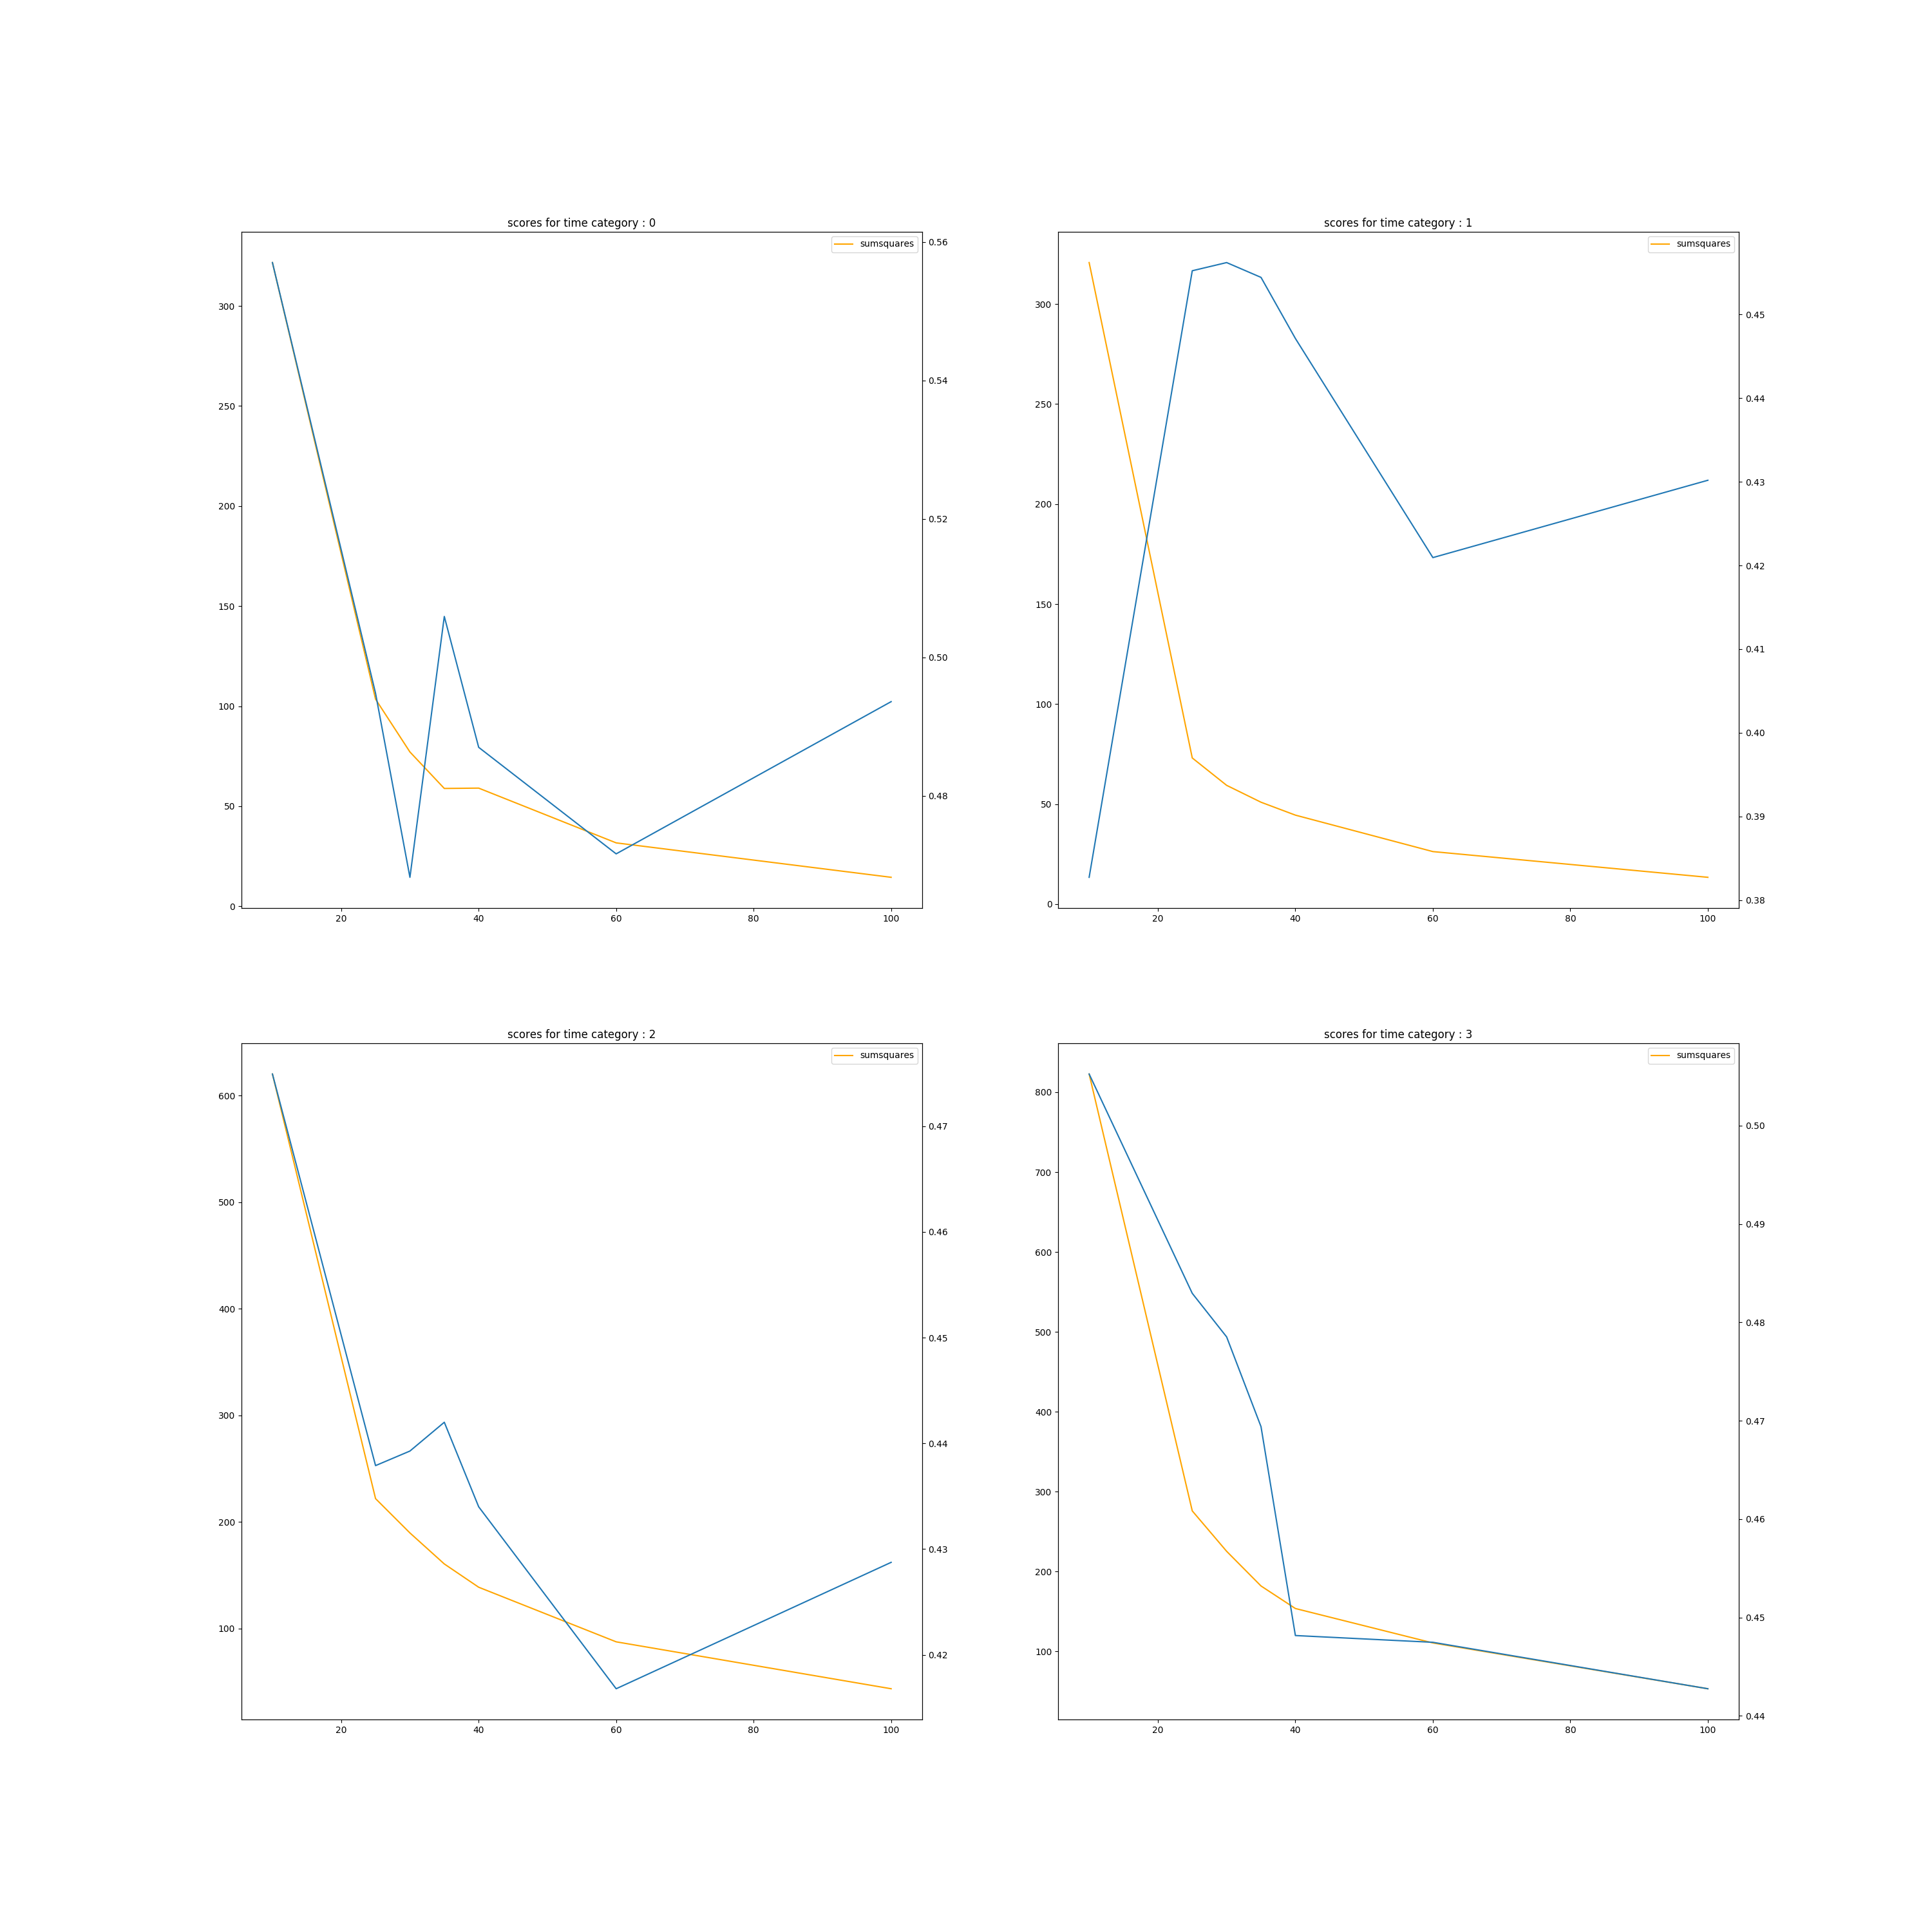

In [86]:
%matplot plt

Using the elbow method on the graphs (above) we identify the following optimal values of k 

In [36]:
optimal_ks = [35,30,35,25,30]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
def give_udf(time_cat):
    '''Given a time category time_cat : return an udf that concatenate the name of a cluster with time_cat'''
    @F.udf(T.StringType())
    def label_cluster(cluster):
        '''concatenate given cluster name and time_cat'''
        return str(time_cat) + ":" + str(cluster)
    return label_cluster

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:

# Here we fit and save all the clusterings in the same dataframe (kmeans_df) , each cluster is then identified by its time category and the cluster name
for i in range(len(time_categories)):
    # fit optimal clustering
    optimal_k = optimal_ks[i]
    opt_kmeans = KMeans(k=optimal_k, seed=3, featuresCol='kmeans_features')
    opt_model = opt_kmeans.fit(kmeans_dfs[i])
    
    # compute the predictions
    kmeans_dfs[i] = opt_model.transform(kmeans_dfs[i])
    kmeans_dfs[i] = kmeans_dfs[i].withColumnRenamed('prediction','cluster').drop('vectorized_features','kmeans_features')
    
    udf = give_udf(i)
    # re identify the cluster using by adding the time category in the name
    kmeans_dfs[i] = kmeans_dfs[i].withColumn('cluster',udf("cluster")).cache()
# re merge
kmeans_df = reduce(DataFrame.unionAll, kmeans_dfs).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# identifier of an edges
identifier = ["start","end","transport_group","time_category"]
# we group the edges using the computed clusters
gamma_fitting_df = delays.join(kmeans_df,identifier)\
                            .groupby("cluster").agg(F.collect_list("arrival_delay").alias("delays")).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
# fit the gammas
fine_grained_gammas = data_utils.distribution_fitting(gamma_fitting_df).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
# sample the data and get result as Pandas DataFrame
fine_grained_gammas_df = data_utils.sample_delays(fine_grained_gammas, ['cluster'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
ncols,nrows= 5,8
fig, axs = plt.subplots(ncols=ncols,nrows=nrows, figsize=(20,10))
# plot some fitted distributions
for i,ax in zip(range(ncols*nrows),axs.flatten()):
    curr_data = fine_grained_gammas_df.iloc[i]
    data_utils.plot_distri(curr_data,ax)
    ax.set_title("cluster :" + str(curr_data.cluster) )

plt.show()
plt.tight_layout()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

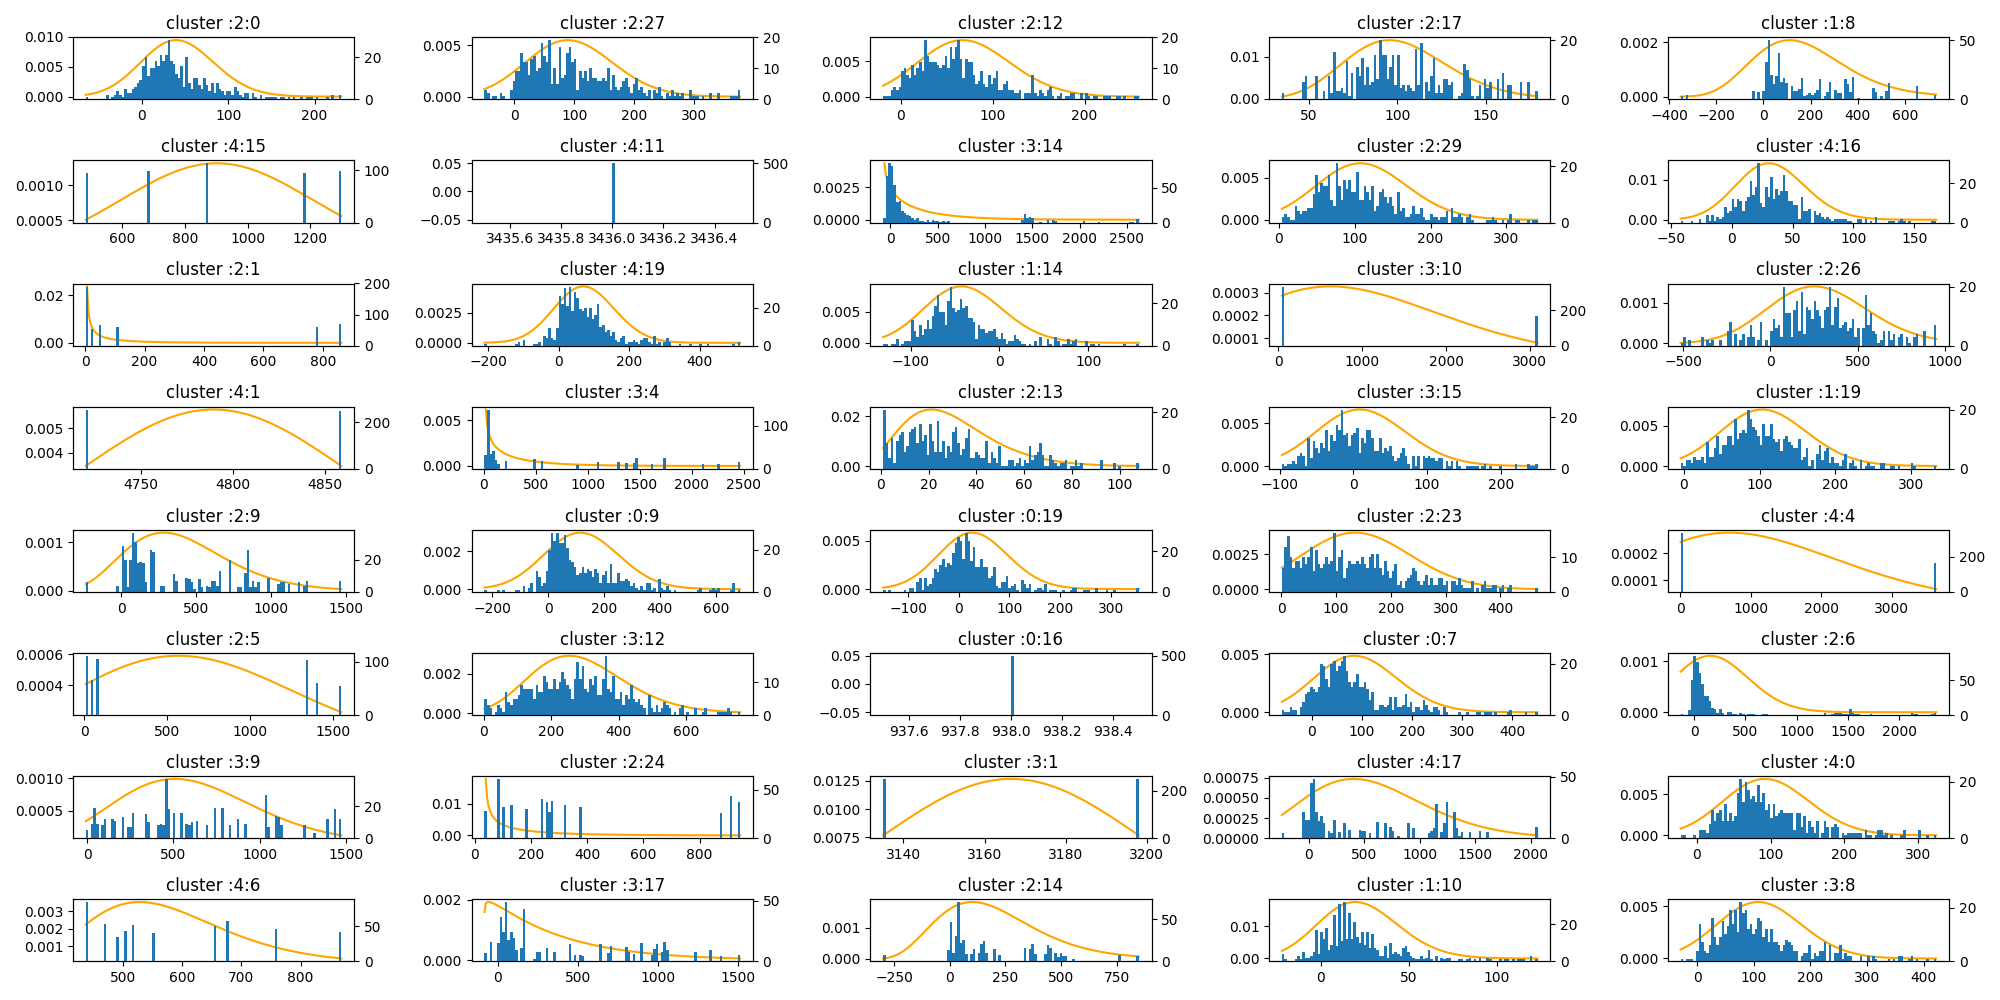

In [106]:
%matplot plt

We see on the above graphs that most of the highly populated clusters are well fitted by the gammas. However, there still exist some clusters with just a few data points (ex : cluster 0:16 has one data). Further improvement is needed on the clustering side. For this reason, we drop clusters with less than 500 data points. Corresponding edges will use the coarse-grained gammas. 

In [44]:
fine_grained_gammas = fine_grained_gammas.withColumn("delays_count",F.size("delays")).filter(F.col("delays_count") < 500).drop("delays_count")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
a.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3752

## Final processing
Now we need to save all the computed gammas the the edge dataset

In [46]:
@F.udf(T.ArrayType(T.FloatType()))
def merge_gammas(gamma,fine_grained_gamma):
    '''given gamma and fine_grained_gamma return fine_grained_gamma if possible otherwise return gamma'''
    return  fine_grained_gamma if fine_grained_gamma else gamma

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
fine_grained_gammas = (fine_grained_gammas.join(kmeans_df,["cluster"])
         .join(delays,identifier)
         .withColumnRenamed('gammas'  , 'fine_grained_gammas')
         .withColumnRenamed('start'  , 'dep_stop_id')
         .withColumnRenamed('end'  , 'arr_stop_id')
          ).cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
edges_with_gammas = edges_with_gammas.join(fine_grained_gammas,["dep_stop_id","arr_stop_id","transport_group","time_category"],how="left")\
                                     .withColumn("gammas",merge_gammas("gammas","fine_grained_gammas"))\
                                     .drop("fine_grained_gammas","delays","line_id","scheduled_departure_time","scheduled_arrival_time","cluster").cache()

## Saving final result

In [ ]:
edges_with_gammas.write.save("/user/boesinge/finalproject/edges_with_gammas_global.parquet",mode="overwrite")